In [1]:
# This is for toggle on/off the raw code
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# 1. Introduction

<img src="./image/Elo_competition.png" width="500" height="500"/>

### It is an ongoing Kaggle competition 
thus, it's an ongoing task. <br>
_https://www.kaggle.com/c/elo-merchant-category-recommendation_

> * Elo is one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders.
<br>
    - Do these promotions work for either the consumer or the merchant?
    - Do customers enjoy their experience?
    - Do merchants see repeat business?
<br>
> * To develop algorithms/machine learning model to ...
<br>
    - understand __the most important aspects and preferences__ in their customers' lifecycle.
    - identify and serve the most relevant opportunities to individuals, by uncovering signal in __customer loyalty__.


# 2. Objective

<img src="./image/logic_flow.png" width="650" height="650"/>

- __Exploratory data analysis (EDA)__
    - Manage missing values
    - Merge datasets
    - Generate possible parameters
    - Visualize datasets

- __Model training and prediction__
    - Select a model: <br>__[Gradient Boosting Decision Tree (GBDT) methods]__<br> random forest/XGBoost/__Light GBM__
    - Adjust parameters for training
    - Use root-mean-squre error (RMSE) to evaluate model performance
    
- __Visualization__
    - Dataset visualization (using matplotlib/seaborn)
    - Model result visualization (using SHapley Additive exPlanations (SHAP))

- __Explanation__
    - Use SHAP, which is a unified approach to explain the output of machine learning model
---
> __The main objective for this project is to...__ <br> <span style="color:red">1. find the __importance of the possible factors__; <br> 2. improve the __model predictability__; <br> 3. __explain the model results__ </span>

# 3. Dataset Exploration

In [2]:
!ls ./data/

Data_Dictionary.xlsx          sample_submission.csv
historical_transactions.csv   test.csv
merchants.csv                 train.csv
new_merchant_transactions.csv


### We are given the above files. Descriptions of the files are shown below:

- __train.csv__: the training set
- test.csv: the test set
- sample_submission.csv: a sample submission file in the correct format - contains all card_ids you are expected to predict for.
- __historical_transactions.csv__: up to 3 month's worth of historical transactions for each card_id
- merchants.csv: additional information about all merchants/merchant_ids in the dataset.
- new_merchant_transcations.csv: two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.



-----
## A. Train and Test set:

In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
import sklearn
from sklearn import model_selection
import shap

In [5]:
shap.initjs()

### (1) Glance at datasets

In [6]:
train_df = pd.read_csv("./data/train.csv", parse_dates=["first_active_month"])
test_df = pd.read_csv("./data/test.csv", parse_dates=["first_active_month"])
hist_df = pd.read_csv("./data/historical_transactions.csv")
print("Number of rows and columns in train set : ", train_df.shape)
print("Number of rows and columns in test set : ", test_df.shape)
print ("Number of rows and columns in test set : ", hist_df.shape)

Number of rows and columns in train set :  (201917, 6)
Number of rows and columns in test set :  (123623, 5)
Number of rows and columns in test set :  (29112361, 14)


__Training set__

In [7]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


__Testing set__

In [8]:
test_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


In [9]:
print ('    [Missing Value Summary]')
pd.set_option('display.float_format', lambda x: '%.3f' %x)
print ('-'*10,'train dataset','-'*10)
print (train_df.isnull().sum() / len(train_df))
print ('-'*10,'test dataset','-'*10)
print (test_df.isnull().sum() / len(test_df))
print ('-'*10,'historical_transactions dataset','-'*10)
print (hist_df.isnull().sum() / len(hist_df))

    [Missing Value Summary]
---------- train dataset ----------
first_active_month   0.000
card_id              0.000
feature_1            0.000
feature_2            0.000
feature_3            0.000
target               0.000
dtype: float64
---------- test dataset ----------
first_active_month   0.000
card_id              0.000
feature_1            0.000
feature_2            0.000
feature_3            0.000
dtype: float64
---------- historical_transactions dataset ----------
authorized_flag        0.000
card_id                0.000
city_id                0.000
category_1             0.000
installments           0.000
category_3             0.006
merchant_category_id   0.000
merchant_id            0.005
month_lag              0.000
purchase_amount        0.000
purchase_date          0.000
category_2             0.091
state_id               0.000
subsector_id           0.000
dtype: float64


It's nice to know __NO MISSING data in the train/test dataset.__<br>
__However, there are some missing data in the categories of <span style="color:red">category_3</span>; <span style="color:red">category_2</span> and <span style="color:red">merchant_id.</span>__

### (2) The target column (loyalty score) in the training set

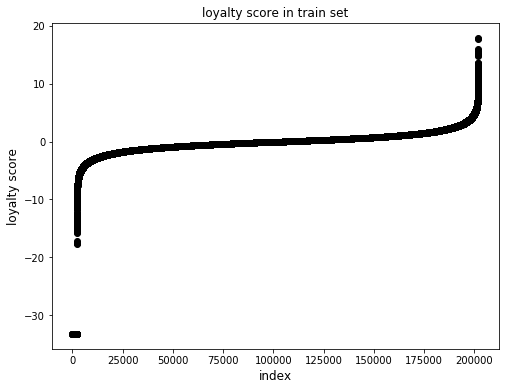

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(0,train_df.shape[0]), np.sort(train_df['target'].values), color='black')
plt.xlabel('index', fontsize=12)
plt.ylabel('loyalty score', fontsize=12)
plt.title('loyalty score in train set', fontsize=12)
plt.show()

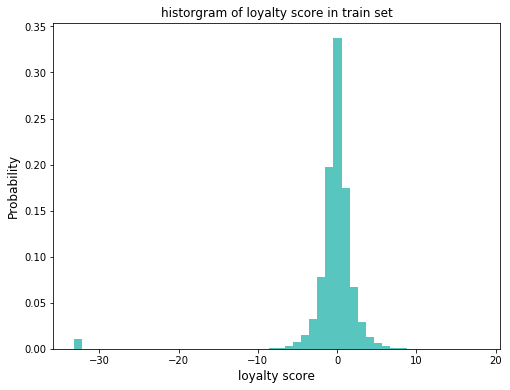

In [11]:
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(train_df['target'].values, 50, density=True, facecolor='lightseagreen', alpha=0.75)
plt.title('historgram of loyalty score in train set', fontsize=12)
plt.xlabel('loyalty score', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.show()

From above two figures, we can see two things:
- Most of the loyalty scores lay between -20 and 20.
- some of the loyalty values are far apart (less than -30) compared to others. 

Let's dig into it. 

<H3><span style="color:blue">Q: How many data has loyalty values less than -30?</span>

In [12]:
print ('A total of ', (train_df['target']<-30).sum(), '(rows) with loyalty values less than -30')

A total of  2207 (rows) with loyalty values less than -30


We have 2207 rows with loyalty values less than -30. It's about __1% of the training data__. <br>
Some statistics might be influenced by these rows (e.g., RMSE, MAE...) so beware of them. <br>
Now, for the first try... 
- set dataframe __low_loyalty__ to identify those data. <br>
- dataframe __train_df_nll__ has removed those low loyalty data.

In [13]:
train_df_nll = train_df.loc[train_df['target']>=-30].reset_index(drop=True)
low_loyalty = train_df.loc[train_df['target']<-30].reset_index(drop=True)
print("Number of rows and columns in train_df_nll : ", train_df_nll.shape)
print("Number of rows and columns in low_loyalty : ", low_loyalty.shape)

Number of rows and columns in train_df_nll :  (199710, 6)
Number of rows and columns in low_loyalty :  (2207, 6)


### (3) how data is distributed with time
`first_active_month` represents the month of first purchase done by the specific credit card.

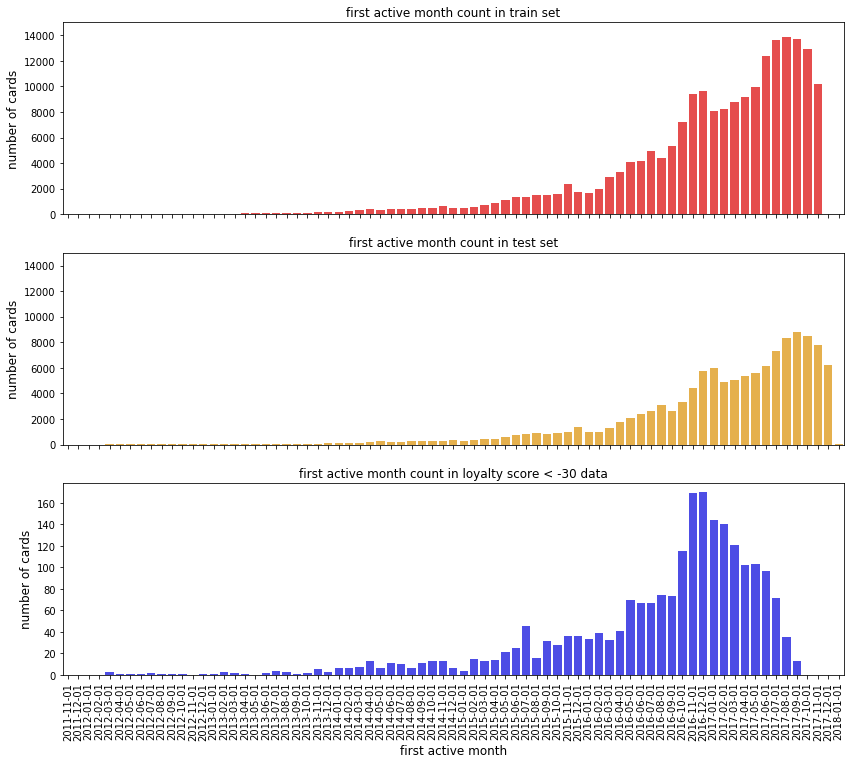

In [14]:
active_months_train = train_df['first_active_month'].dt.date.value_counts()
active_months_train = active_months_train.sort_index()

active_months_test = test_df['first_active_month'].dt.date.value_counts()
active_months_test = active_months_test.sort_index()

active_months_low_loyalty = low_loyalty['first_active_month'].dt.date.value_counts()
active_months_low_loyalty = active_months_low_loyalty.sort_index()

## -- this process is to set the same time index for three datasets --
active_months_train_df = active_months_train.to_frame()
active_months_train_df = active_months_train_df.reset_index()

active_months_low_loyalty_df = active_months_low_loyalty.to_frame()
active_months_low_loyalty_df = active_months_low_loyalty_df.rename(columns={'first_active_month':'ll_first_active_month'})
active_months_low_loyalty_df = active_months_low_loyalty_df.reset_index()
temp_df = active_months_train_df.merge(active_months_low_loyalty_df ,how='outer')
active_months_low_loyalty_values_forplot = temp_df['ll_first_active_month']
## -------------------------------------------------------------------

fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

sns.barplot(active_months_train.index, active_months_train.values, alpha=0.8, color='red',ax=ax1)
sns.barplot(active_months_test.index, active_months_test.values, alpha=0.8, color='orange',ax=ax2)
sns.barplot(active_months_test.index, active_months_low_loyalty_values_forplot, alpha=0.8, color='blue',ax=ax3)
ax1.set_title('first active month count in train set', fontsize=12)
ax2.set_title('first active month count in test set', fontsize=12)
ax3.set_title('first active month count in loyalty score < -30 data', fontsize=12)
ax3.set_xlabel('first active month', fontsize=12)
ax1.set_ylabel('number of cards', fontsize=12)
ax2.set_ylabel('number of cards', fontsize=12)
ax3.set_ylabel('number of cards', fontsize=12)
ax1.set_ylim([0,15000])
ax2.set_ylim([0,15000])
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.xaxis.set_tick_params(rotation=90)

The train and test dataset has similar time distribution. So we do not need to (or at least worry later) do time-based split. <br>
Notice that data with low loyalty score (<-30) has different time distribution compared to the train/test dataset. It means if we need to remove these data, we might concern data is forced to be missed in a biased way in terms of time.

### (4) Relationship of features (1, 2, and 3) and loyalty scores 

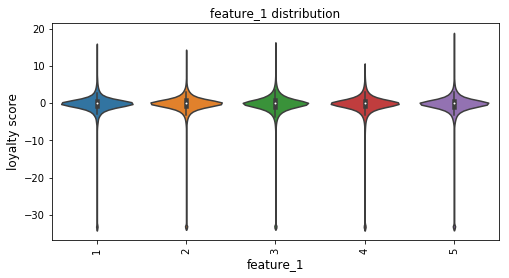

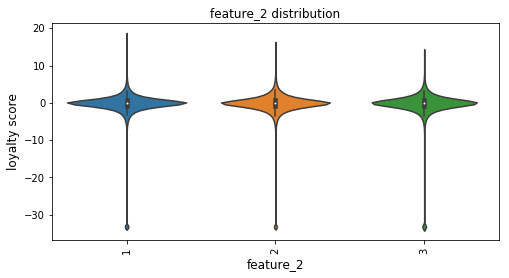

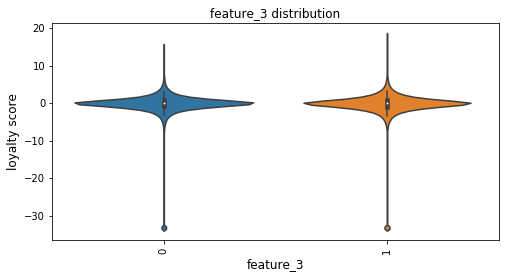

In [15]:
# feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y="target", data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('feature_1', fontsize=12)
plt.ylabel('loyalty score', fontsize=12)
plt.title("feature_1 distribution")
plt.show()

# feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y="target", data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('feature_2', fontsize=12)
plt.ylabel('loyalty score', fontsize=12)
plt.title("feature_2 distribution")
plt.show()

# feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y="target", data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('feature_3', fontsize=12)
plt.ylabel('loyalty score', fontsize=12)
plt.title("feature_3 distribution")
plt.show()

The distribution of the different categories in three features look alike.  

-----
## B. Historical Transcations:

In [16]:
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703,2017-06-25 15:33:07,1.000,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733,2017-07-15 12:10:45,1.000,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720,2017-08-09 22:04:29,1.000,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735,2017-09-02 10:06:26,1.000,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.723,2017-03-10 01:14:19,1.000,16,37


The field descriptions are as follows:

- card_id - card identifier
- month_lag - month lag to reference date
- purchase_date - Purchase date
- authorized_flag - 'Y' if approved, 'N' if denied
- category_3 - anonymized category
- installments - number of installments of purchase
- category_1 - anonymized category
- merchant_category_id - Merchant category identifier (anonymized )
- subsector_id - Merchant category group identifier (anonymized )
- merchant_id - Merchant identifier (anonymized)
- purchase_amount - Normalized purchase amount
- city_id - City identifier (anonymized )
- state_id - State identifier (anonymized )
- category_2 - anonymized category

### (1) Visualize historical transactions
Have a glance at historical transcations. Before generating features and merging transcation data with training set, we need to do exploratory dataset analysis.

### - Month_lag 
__month lag to reference date.__<br>
The reference date is the latest purchase date shown in the historical transaction dataset.  That means more transcations are made/recorded at later time period in the dataset.

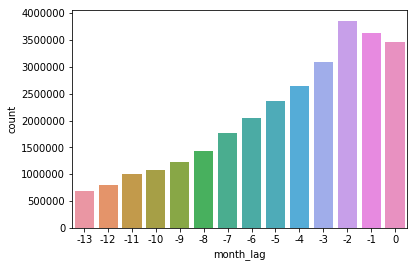

In [17]:
sns.countplot(hist_df.month_lag)

### - Purchase amount
__Normalized purchase amount.__<br>
We can find some purchase amount is extremely high for some transactions. To avoid these data having signficant impacts on the machine learning, we'll remove those high data.

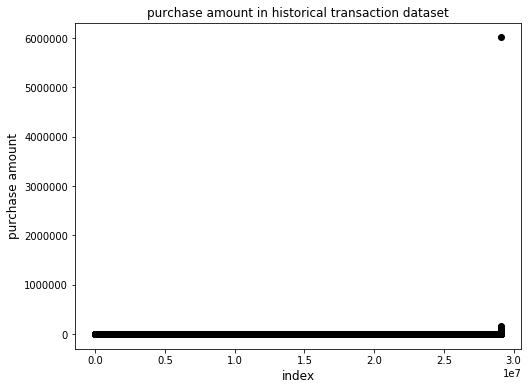

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(0,hist_df.shape[0]), np.sort(hist_df['purchase_amount'].values), color='black')
plt.xlabel('index', fontsize=12)
plt.ylabel('purchase amount', fontsize=12)
plt.title('purchase amount in historical transaction dataset', fontsize=12)
plt.show()

In [19]:
modhist_df = hist_df.loc[hist_df['purchase_amount'] < 50000.].reset_index(drop=True)

### (2) Generate parameters/features for machine learning
Let us make some features based on the historical transactions and merge them with train and test set.

In [20]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    df['category_2_1'] = np.where(df['category_2']==1,1,0)
    df['category_2_2'] = np.where(df['category_2']==2,1,0)
    df['category_2_3'] = np.where(df['category_2']==3,1,0)
    df['category_2_4'] = np.where(df['category_2']==4,1,0)
    df['category_2_5'] = np.where(df['category_2']==5,1,0)

    df['category_3_A'] = np.where(df['category_3']=="A",1,0)
    df['category_3_B'] = np.where(df['category_3']=="B",1,0)
    df['category_3_C'] = np.where(df['category_3']=="C",1,0)
    
    return df

In [21]:
histtrans_df = binarize(hist_df)
modhisttrans_df = binarize(modhist_df)

In [22]:
histtrans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,state_id,subsector_id,category_2_1,category_2_2,category_2_3,category_2_4,category_2_5,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703,...,16,37,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733,...,16,16,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720,...,16,37,1,0,0,0,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735,...,16,34,1,0,0,0,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.723,...,16,37,1,0,0,0,0,1,0,0


In [23]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean','count'],
        'category_1': ['sum', 'mean'],
        'category_2_1': ['sum', 'mean'],
        'category_2_2': ['sum', 'mean'],
        'category_2_3': ['sum', 'mean'],
        'category_2_4': ['sum', 'mean'],
        'category_2_5': ['sum', 'mean'],
        'category_3_A': ['sum', 'mean'],
        'category_3_B': ['sum', 'mean'],
        'category_3_C': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max', 'std', 'mean']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [24]:
history = aggregate_transactions(histtrans_df)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
mod_history = aggregate_transactions(modhisttrans_df)
mod_history.columns = ['hist_' + c if c != 'card_id' else c for c in mod_history.columns]
history.head()

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_authorized_flag_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1_sum,hist_category_2_1_mean,hist_category_2_2_sum,...,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max,hist_month_lag_std,hist_month_lag_mean
0,C_ID_00007093c1,149,114,0.765,149,28,0.188,0,0.000,0,...,192,1.289,6,1,0.765,32627654.000,-12,0,3.453,-5.852
1,C_ID_0001238066,123,120,0.976,123,2,0.016,95,0.772,0,...,198,1.610,10,-1,1.486,13110825.000,-5,0,1.289,-1.813
2,C_ID_0001506ef0,66,62,0.939,66,0,0.000,2,0.030,0,...,1,0.015,1,0,0.123,34460275.000,-13,0,4.238,-4.833
3,C_ID_0001793786,216,189,0.875,216,2,0.009,11,0.051,76,...,5,0.023,1,0,0.151,24487497.000,-9,0,2.306,-3.329
4,C_ID_000183fdda,144,137,0.951,144,4,0.028,7,0.049,1,...,264,1.833,10,-1,2.119,17492874.000,-6,0,1.895,-2.451


In [25]:
org_train_df = pd.merge(train_df, history, on="card_id", how="left")
org_test_df = pd.merge(test_df, history, on="card_id", how="left")
org_train_df_nll = pd.merge(train_df_nll, history, on="card_id", how="left")

mod_train_df = pd.merge(train_df, mod_history, on="card_id", how="left")
mod_test_df = pd.merge(test_df, mod_history, on="card_id", how="left")
mod_train_df_nll = pd.merge(train_df_nll, mod_history, on="card_id", how="left")

In [26]:
org_train_df["year"] = org_train_df["first_active_month"].dt.year
org_test_df["year"] = org_test_df["first_active_month"].dt.year
org_train_df_nll["year"] = org_train_df_nll["first_active_month"].dt.year
org_train_df["month"] = org_train_df["first_active_month"].dt.month
org_test_df["month"] = org_test_df["first_active_month"].dt.month
org_train_df_nll["month"] = org_train_df_nll["first_active_month"].dt.month

In [27]:
mod_train_df["year"] = mod_train_df["first_active_month"].dt.year
mod_test_df["year"] = mod_test_df["first_active_month"].dt.year
mod_train_df_nll["year"] = mod_train_df_nll["first_active_month"].dt.year
mod_train_df["month"] = mod_train_df["first_active_month"].dt.month
mod_test_df["month"] = mod_test_df["first_active_month"].dt.month
mod_train_df_nll["month"] = mod_train_df_nll["first_active_month"].dt.month

In [28]:
cols_to_use = list(org_test_df.columns.values)
cols_to_use.remove('first_active_month')
cols_to_use.remove('card_id')

# 4. Machine learning 

## A. Overview of ensemble learning

<img src="./image/gbdt_all.png" width="800" height="800"/>

`error = bias + variance `

- __Boosting__ is based on __weak learners (high bias, low variance)__. In terms of decision trees, weak learners are __shallow trees__, sometimes even as small as decision stumps (trees with two leaves). Boosting reduces error mainly by __reducing bias__ (and also to some extent variance, by aggregating the output from many models).

- On the other hand, __Random Forest__ uses as you said __fully grown decision trees (low bias, high variance)__. It tackles the error reduction task in the opposite way: by __reducing variance__. The trees are made uncorrelated to maximize the decrease in variance, but the algorithm cannot reduce bias (which is slightly higher than the bias of an individual tree in the forest). Hence the need for large, unpruned trees, so that the bias is initially as low as possible.

## B. Gradient boosted decision tree (GBDT)

<img src="./image/gbdt.png" width="500" height="500"/>

<img src="./image/LGBM_example.png" width="500" height="500"/>

- Boosting is sequential while Bagging is parallel

## C. XGBoost versus Light GBM

<img src="./image/comparison.png" width="500" height="500"/>

> "Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks."

## A. Train set & evaluation

In [29]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

train_X = org_train_df[cols_to_use]
test_X = org_test_df[cols_to_use]
train_y = org_train_df['target'].values

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2019, shuffle=True)
for fit_index, val_index in kf.split(org_train_df):
    fit_X, val_X = train_X.loc[fit_index,:], train_X.loc[val_index,:]
    fit_y, val_y = train_y[fit_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(fit_X, fit_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
pred_test /= 5.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.84793
[200]	valid_0's rmse: 3.84508
[300]	valid_0's rmse: 3.84505
Early stopping, best iteration is:
[228]	valid_0's rmse: 3.84465
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.75967
[200]	valid_0's rmse: 3.7582
[300]	valid_0's rmse: 3.75914
Early stopping, best iteration is:
[229]	valid_0's rmse: 3.75761
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.65503
[200]	valid_0's rmse: 3.65504
Early stopping, best iteration is:
[142]	valid_0's rmse: 3.65418
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.89126
[200]	valid_0's rmse: 3.8905
Early stopping, best iteration is:
[147]	valid_0's rmse: 3.88962
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.68595
[200]	valid_0's rmse: 3.68736
Early stopping, best iteration is:
[107]	valid_0's rmse: 3.68559


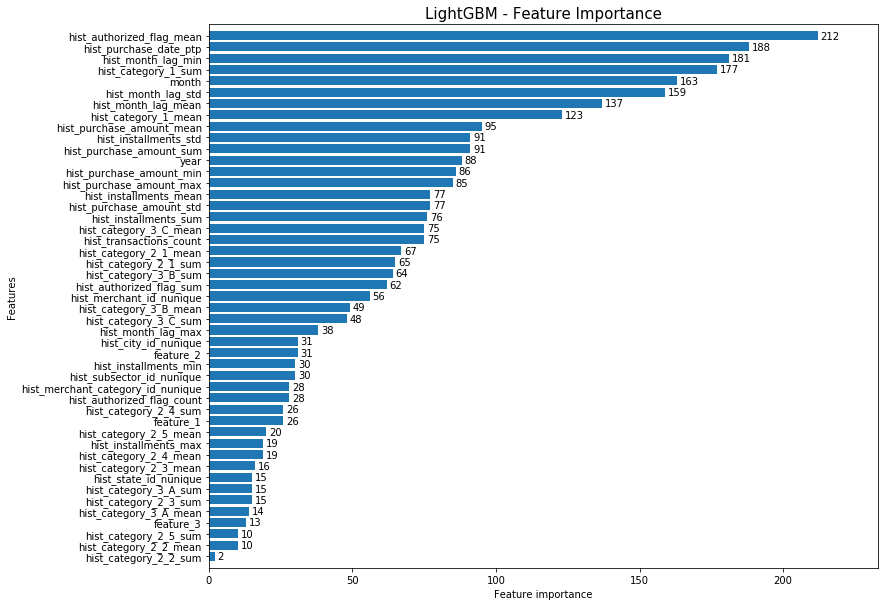

In [30]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

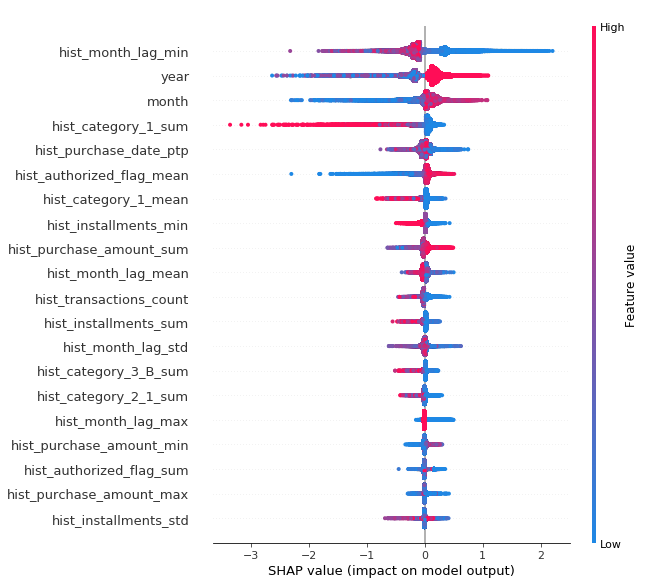

In [31]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)

## B. Train set (remove low loyalty data) & evaluation

In [33]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

train_X = org_train_df_nll[cols_to_use]
test_X = org_test_df[cols_to_use]
train_y = org_train_df_nll['target'].values

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2019, shuffle=True)
for fit_index, val_index in kf.split(org_train_df_nll):
    fit_X, val_X = train_X.loc[fit_index,:], train_X.loc[val_index,:]
    fit_y, val_y = train_y[fit_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(fit_X, fit_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
pred_test /= 5.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.72265
[200]	valid_0's rmse: 1.72247
[300]	valid_0's rmse: 1.72263
Early stopping, best iteration is:
[239]	valid_0's rmse: 1.72233
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69547
[200]	valid_0's rmse: 1.69546
Early stopping, best iteration is:
[193]	valid_0's rmse: 1.69539
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69177
[200]	valid_0's rmse: 1.69172
Early stopping, best iteration is:
[177]	valid_0's rmse: 1.69155
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70234
Early stopping, best iteration is:
[95]	valid_0's rmse: 1.70229
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70861
[200]	valid_0's rmse: 1.70889
Early stopping, best iteration is:
[108]	valid_0's rmse: 1.70855


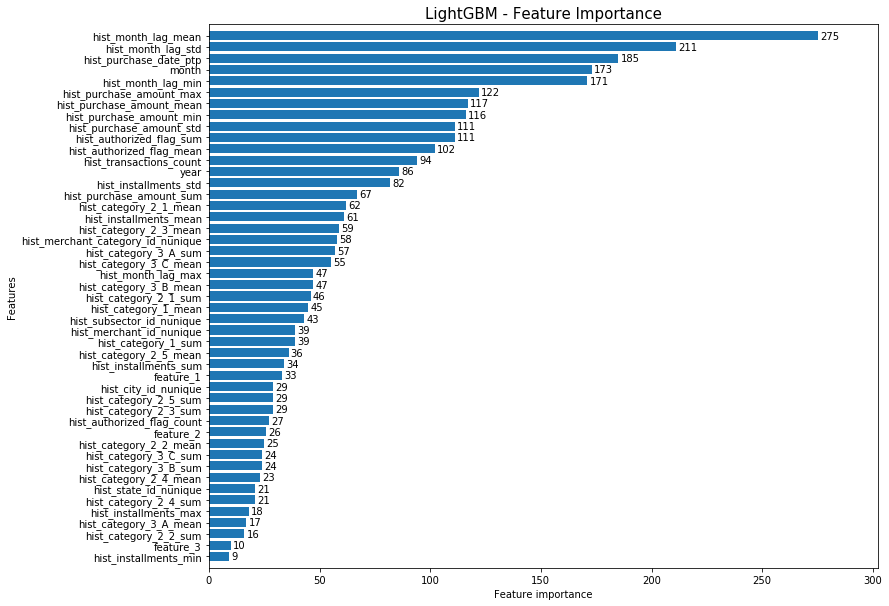

In [34]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

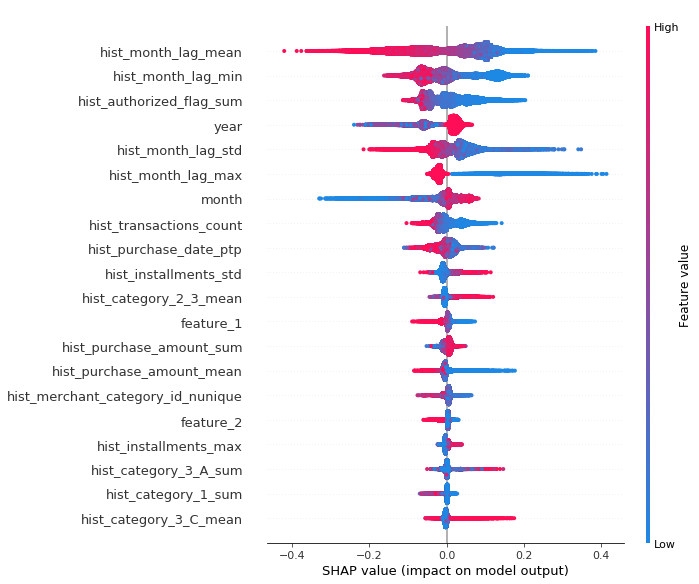

In [35]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)

## C. Train set (remove high purchase amount & low loyalty data) & evaluation


In [37]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

train_X = mod_train_df_nll[cols_to_use]
test_X = org_test_df[cols_to_use]
train_y = mod_train_df_nll['target'].values

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2019, shuffle=True)
for fit_index, val_index in kf.split(mod_train_df_nll):
    fit_X, val_X = train_X.loc[fit_index,:], train_X.loc[val_index,:]
    fit_y, val_y = train_y[fit_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(fit_X, fit_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
pred_test /= 5.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.72296
Early stopping, best iteration is:
[80]	valid_0's rmse: 1.72285
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.6954
[200]	valid_0's rmse: 1.69514
[300]	valid_0's rmse: 1.6953
Early stopping, best iteration is:
[208]	valid_0's rmse: 1.69509
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.69219
[200]	valid_0's rmse: 1.69219
Early stopping, best iteration is:
[139]	valid_0's rmse: 1.69199
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70228
[200]	valid_0's rmse: 1.70238
Early stopping, best iteration is:
[170]	valid_0's rmse: 1.70215
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.70817
[200]	valid_0's rmse: 1.70865
Early stopping, best iteration is:
[119]	valid_0's rmse: 1.70806


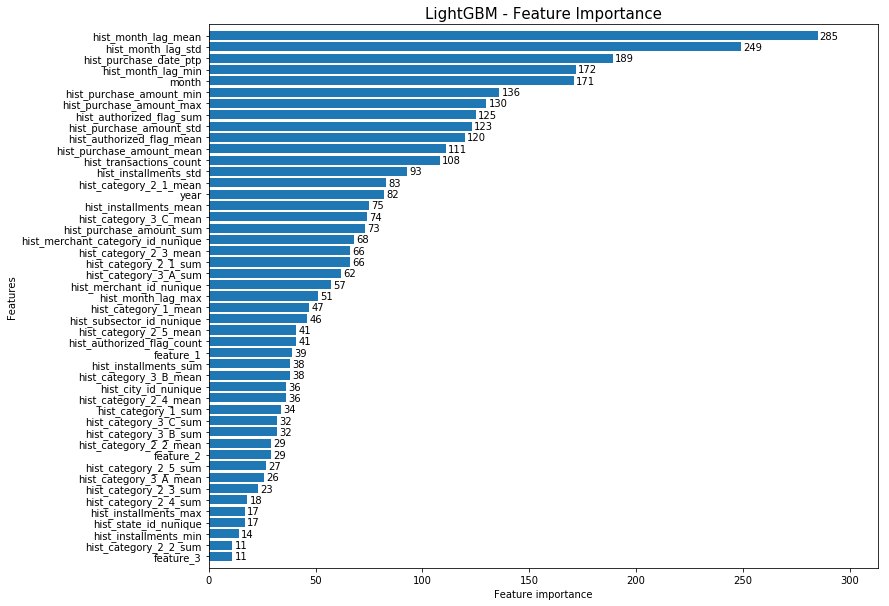

In [38]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [44]:
shap.force_plot(explainer.expected_value, shap_values[0,:], test_X.iloc[0,:])

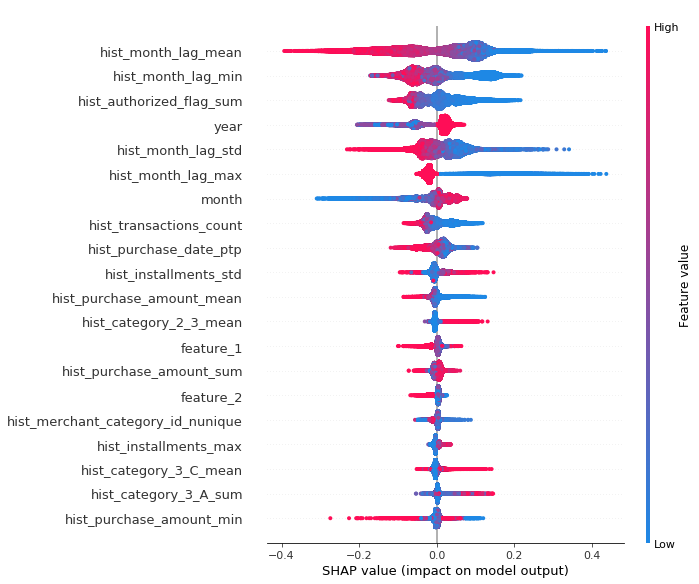

In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)

## 5. Explanation

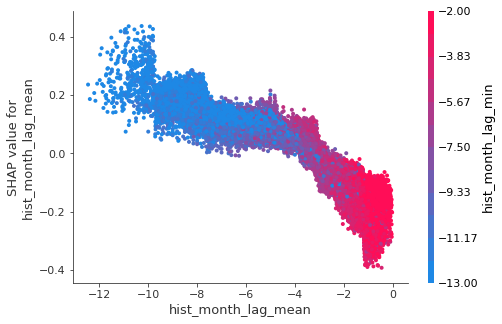

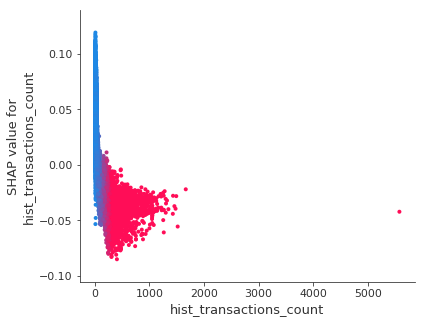

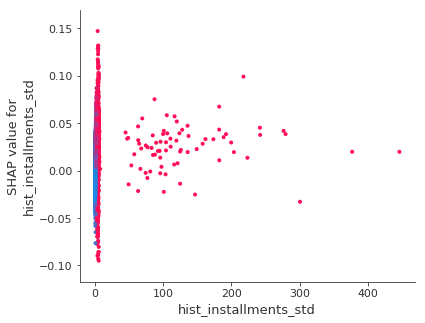

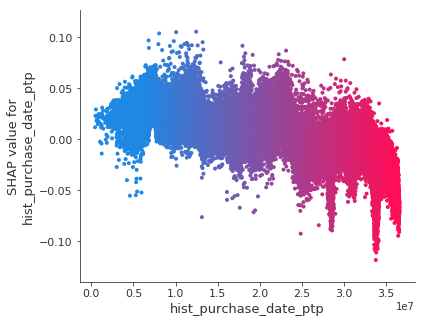

In [49]:
shap.dependence_plot("hist_month_lag_mean", shap_values, test_X, interaction_index="hist_month_lag_min")
shap.dependence_plot("hist_transactions_count", shap_values, test_X, interaction_index="hist_transactions_count")
shap.dependence_plot("hist_installments_std", shap_values, test_X, interaction_index="hist_installments_std")
shap.dependence_plot("hist_purchase_date_ptp", shap_values, test_X, interaction_index="hist_purchase_date_ptp")